In [2]:
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import copy
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import datetime
from imblearn.over_sampling import SMOTE 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_auc_score

In [16]:
df2 = pd.read_csv(r'/Users/kolokolcevalexey/Desktop/archive/movie.csv')

In [17]:
df1 = pd.read_csv(r'/Users/kolokolcevalexey/Desktop/archive/credits.csv')

In [18]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [19]:
df2.overview[0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [20]:
C = df2['vote_average'].mean()
C

6.092171559442011

In [21]:
m = df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [22]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [23]:
ProfileReport(df2)

KeyboardInterrupt: 

In [24]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

<AxesSubplot:>

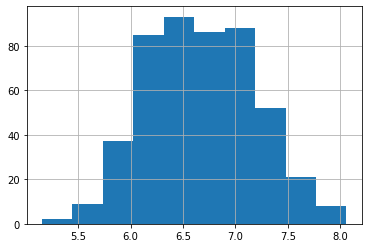

In [26]:
q_movies.score.hist()

In [27]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

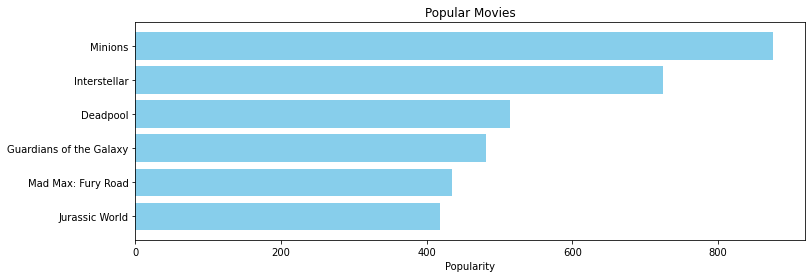

In [28]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [29]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [30]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

In [31]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [33]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [34]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [35]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

In [36]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [37]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [38]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [39]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [40]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [41]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [42]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [43]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [44]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [45]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [46]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [47]:
get_recommendations('Titanic', cosine_sim2)

1081             Revolutionary Road
4247          Me You and Five Bucks
49                 The Great Gatsby
872              All the King's Men
1311                     Angel Eyes
1492                     The Reader
2449          Sense and Sensibility
2661                 Romeo + Juliet
2701                Little Children
2946    What's Eating Gilbert Grape
Name: title, dtype: object

In [48]:
get_recommendations('The Godfather: Part II', cosine_sim2)

867      The Godfather: Part III
3337               The Godfather
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
3538          Do the Right Thing
1018             The Cotton Club
1209               The Rainmaker
1338                      John Q
1394               Donnie Brasco
Name: title, dtype: object

In [49]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv(r'/Users/kolokolcevalexey/Desktop/archive2/ratings_small.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [50]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

AttributeError: 'DatasetAutoFolds' object has no attribute 'split'

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

In [ ]:
svd.predict(1, 302, 3)